# PID digital controller: Python implementation

The aim of this tutorial is to implement temperature control on the TCLab board. The successive stages will be:
- definition of the continuous PID corrector from the transfer function identified previously.
- determining the maximum sampling time required to maintain a sufficient phase margin.
- digitalisation of the corrector in the form of a recurrence equation.
- analysis of real performances.

## Requirements

> **Exercice:** Complete the requirements for the temperature control in the following table.

| Requirement | Assessment Criteria  | Level |
| :-: | :-: | :-: |
Control the temperature at 30°C  | Temperature reference tracking | 10% error max.
| Settling time at 5 % | As short as possible
| Overshoot | Less than 10% 
| Disturbance rejection | As high as possible

## Continuous controller 

### System transfer functions

In previous work, we identified the transfer function linking the heating control (input) $Q_1$ to the temperature (output) $T_1$ as second order:

$G_1(p) = \frac{\Delta T_1(p)}{Q_1(p)}=  \frac{0.65}{(27p + 1)(160p + 1)} $

with $\Delta T_1$ expressing the relative difference between the sensor temperature and the ambient temperature (around 20°C).

> **Question:** Approximate the transfer function $G_1(p)$ as a 1st order with pure delay.

$ G_1(s) = \frac{\Delta T_1(s)}{Q_1(s)}= \frac{0.65e^{-27s}}{160s + 1} $


### Zielgler-Nichols method

The Ziegler-Nichols approach to setting PID controllers can be used as an initial parameterisation. This approach is based on a transfer function of the form: 
$ G(s) = \frac{Ke^{-Ls}}{\tau s + 1} $ with $R=K/\tau$ 
with
- $K$ : the steady-state gain;
- $\tau$ : the dominant time-constant;
- $L$ : the pure time-delay.  

The form (P, PI, PD or PID) of the PID controller can then be chosen according to the value of $\tau$ compared
to $L$ by using following table: 

| $\frac{Time Constant}{Delay}=\frac{\tau}{L}$ | Best controller |
| :-: | :-: |
| $\frac{\tau}{L} > 20 $ | On-Off controller |
| $10 < \frac{\tau}{L} < 20 $ | P controller |
| $5 < \frac{\tau}{L} < 10 $ | PI controller |
| $2 < \frac{\tau}{L} < 5 $ | PID controller | 
 
Then the following table defines the parameters of a P, PI or PID controller:
$G_c(s)=k_p(1+\frac{1}{\tau_i s}+\tau_d s)=k_p+\frac{k_i}{s}+k_s s$

|Type|$k_p$|$k_i$|$k_d$|
| :-: | :-: | :-: | :-: |
| P | $\frac{1}{RL}$ | | |
| PI | $\frac{0.9}{RL}$ |$\frac{3}{10RL^2}$ | |
| PID | $\frac{1.2}{RL}$ |$\frac{0.6}{RL^2}$ | $\frac{0.6}{R}$ |


> **Exercice:**  Select and calculate the corrector. 

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Ziegler Nichols input parameter
tau = 160 # [s] time constant of the 1st order
L= 27 # [s] delay
K = 0.65 # [°/%] static gain

R=K/tau

# Controller type 
print("Tau / L ratio = %.2f"%(tau/L))


Tau / L ratio = 5.93


A PI controller seems to be sufficient. 

In [3]:
# controller coefficient with Ziegler Nichols approach

# First try
Kp = 0.9/R/L
Ki = 3/10/R/L**2
Kd = 0

print("PID coefficient (parrallel form): ")
print("Kp = %.3f"%Kp)
print("Ki = %.3f"%Ki)
print("Kd = %.3f"%Kd)

PID coefficient (parrallel form): 
Kp = 8.205
Ki = 0.101
Kd = 0.000


### Temporal performances

> **Exercice:** Analyse the performance by simulation in terms of time: the following code should plot the time response $T_1$ to a 1° step order. It is also interesting to plot the power demand $Q_1$. You can use `tf`, `step` from `control.matlab` package.   

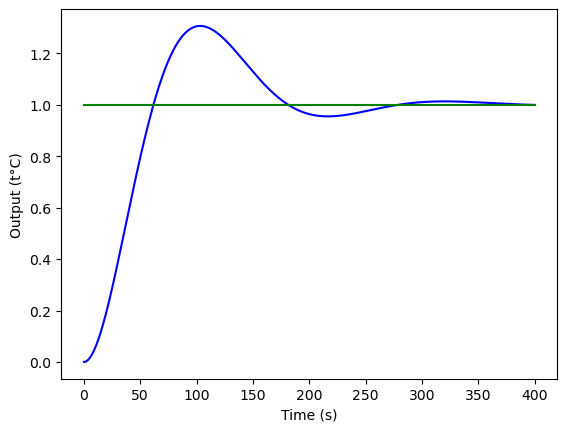

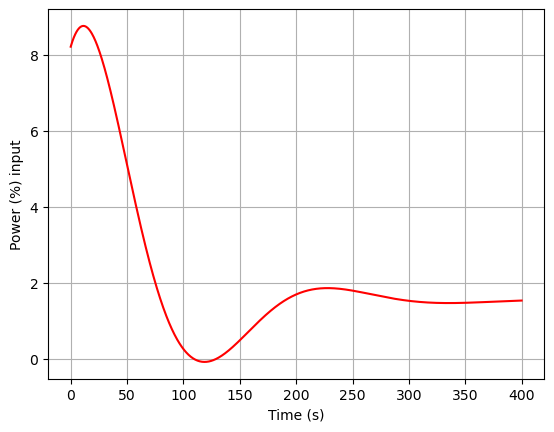

In [11]:
import control.matlab as control

# system transfer function, based on second order model
G1 = 0.65*control.tf([1],[27,1])*control.tf([1],[160,1])

# controller and global model transfer functions
Gc = control.tf([Kd,Kp, Ki],[1, 0]) # PID controller
T = Gc*G1 # Open loop with PID controller
H = T/(1+T) # Closed loop

# Step response of the closed loop
t = np.linspace(0,400,1000)
y,t = control.step(H,t)
Q,t = control.step(Gc/(1+T),t)
plt.plot(t,y, 'b', t,np.ones(1000),'g-')
plt.xlabel('Time (s)')
plt.ylabel('Output (t°C)')
plt.show()

plt.plot(t,Q, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Power (%) input')
plt.grid()
plt.show()

**First form:** PID coefficient (parrallel form)  
Kp = 8.205  
Ki = 0.101  
Kd = 0.000  

Analysis: 
- No static error
- No use of negative power (not possible in our case!)



### Frequency performances

By plotting the Bode and Nichols diagrams in open or closed loops, we can establish the stability margins and the bandwidth.

> **Exercice:** Analyse the frequency performances with Bode plots in open loop and closed loop. Adjust PID gains if necessary. Nichols diagram can be also usefull. You can use `bode` (with `margins=True` parameter), `nichols` from `control.matlab` package.   

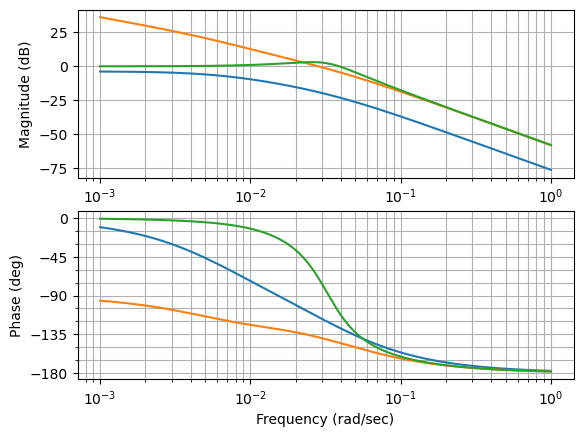

In [12]:
# Bode diagram of open loops
mag,phase,omega = control.bode(G1,T,H)

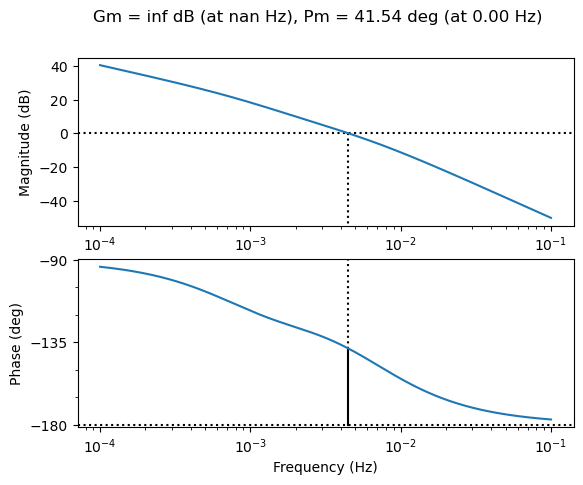

In [13]:
# Print phase and gain margins
mag,phase,omega = control.bode(T, margins = True, Hz=True)

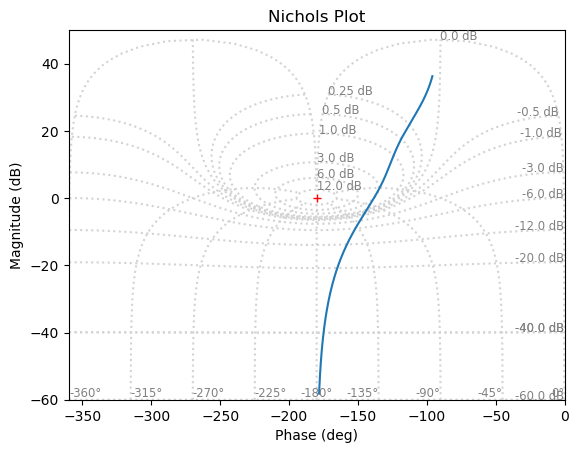

In [7]:
# Print phase and gain margins
control.nichols(T)

**First form:** PID coefficient (parrallel form)  
Kp = 8.205  
Ki = 0.101  
Kd = 0.000  

Analysis: The phase margin is small ==> 50° min for 5° loss with digital controller

### Optimal design of the controller

> **Exercice:** Using the observations made, define an optimum design for the controller. This can be done using an optimisation algorithm such as `scipy.optimize.fmin_slsqp(func, x0, bounds, f_ieqcons)` from the `scipy` package where
>- `func` is a function which return the objective to be minimised
>- `f_ieqcons` is a function which return one or more constraints that must be positive in order to be respected.
>- `x0` is the initial set of parameter (vector) for objective anc ocnstraints functions.


In [14]:
import scipy

# Problem definition
def optim_model(x, param):
    Kp=x[0]
    Ki=x[1]
    Kd=0
    # controller and global model transfer functions
    Gc = control.tf([Kd,Kp, Ki],[1, 0]) # PID controller
    T = Gc*G1 # Open loop with PID controller
    gm, pm, wcg, wcp = control.margin(T)
    
    if (param=='constraints'):
        return [(pm-50)]
    elif (param=='objective'):
        return 1/(wcp/2/3.14)

# Initial point
Kp = 0.9/R/L
Ki = 3/10/R/L**2
Kd = 0
    
InitPoint=np.array([Kp,Ki])    

bounds=[(0.6*Kp, 1.5*Kp),
        (0.6*Ki, 1.5*Ki)]

print('Bounds =', bounds)
# Resolution of the problem


contrainte = lambda x: optim_model(x, "constraints")
objectif = lambda x: optim_model(x, "objective")

result = scipy.optimize.fmin_slsqp(
    func=objectif,
    x0=InitPoint,
    bounds=bounds,
    f_ieqcons=contrainte,
    iter=1000,
    acc=1e-5,
)


Bounds = [(4.923076923076923, 12.30769230769231), (0.06077872744539411, 0.15194681861348527)]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 197.5323372680043
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 9


PID coefficient (parrallel form): 
Kp = 10.336
Ki = 0.061 or Tau_i= 170.05 s
Kd = 0.000 or Tau_d = 0.00 s


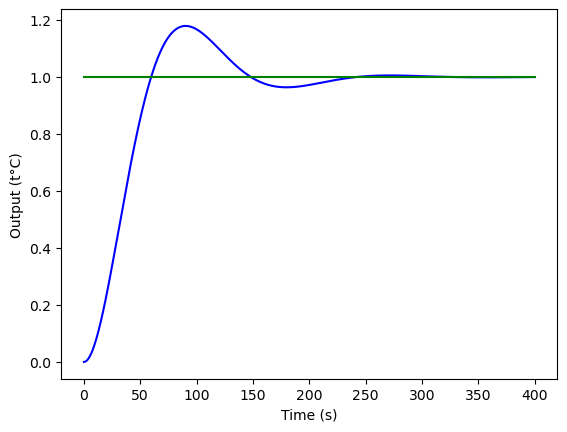

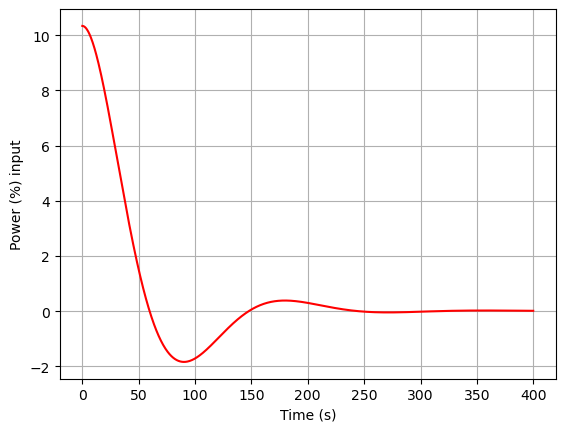

In [16]:
# First try
Kp = result[0]
Ki = result[1]
Kd = 0

print("PID coefficient (parrallel form): ")
print("Kp = %.3f"%Kp)
print("Ki = %.3f or Tau_i= %.2f s"%(Ki,Kp/Ki))
print("Kd = %.3f or Tau_d = %.2f s"%(Kd,Kd/Kp))

# controller and global model transfer functions
Gc = control.tf([Kd,Kp, Ki],[1, 0]) # PID controller
T = Gc*G1 # Open loop with PID controller
H = T/(1+T) # Closed loop

# Step response of the closed loop
t = np.linspace(0,400,1000)
y,t = control.step(H,t)
Q,t = control.step(Kp/(1+T),t)

plt.plot(t,y, 'b', t,np.ones(1000),'g-')
plt.xlabel('Time (s)')
plt.ylabel('Output (t°C)')
plt.show()

plt.plot(t,Q, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Power (%) input')
plt.grid()
plt.show()


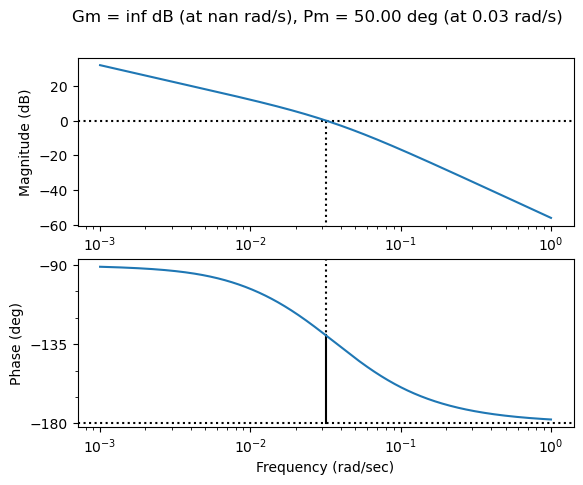

In [17]:
# Print phase and gain margins
mag,phase,omega = control.bode(T, margins = True)

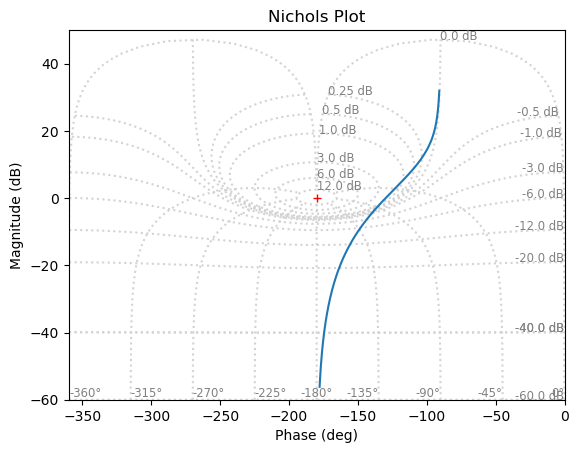

In [18]:
# Print phase and gain margins
control.nichols(T)

## Digital controller 

 ### Definition of minimum sampling time

> **Exercise:** Calculate the minimum sampling time required to avoid degrading the phase margin by more than 5°.  Check your result using Padé's approximation.

Maximum sampling time: 5.49e+00 s


<Figure size 640x480 with 0 Axes>

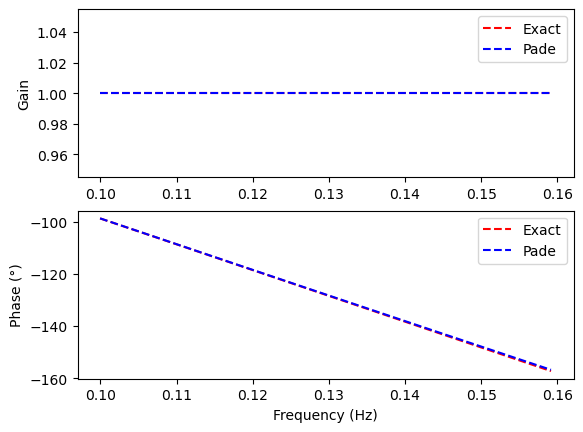

In [19]:
# Phase = -delay.w = 5° where delay=Ts/2
gm, pm, wcg, wcp = control.margin(T)
T_s = 5*np.pi/180* 2/wcp

print("Maximum sampling time: %.2e s"%T_s)

delay=T_s/2

num,den=control.pade(delay, 3)
pade=control.tf(num,den)

mag, phase, omega= control.bode(pade, plot=False, omega_limits=[1,2*3.14*.1], Hz=False)
                        

import matplotlib.pyplot as plt
import numpy as np

freq=omega/2/np.pi

plt.tight_layout()
fig, (ax1, ax2) = plt.subplots(2)    # get subplot axes

plt.sca(ax1)                 # magnitude plot
plt.plot(freq, [1]*len(omega),'r--', label='Exact')
plt.plot(freq, mag,'b--', label='Pade')
plt.ylabel('Gain')
plt.legend()

plt.sca(ax2)                 # phase plot
plt.plot(freq,-delay*omega*180/np.pi,'r--', label='Exact')
plt.plot(freq, phase*180/np.pi,'b--', label='Pade')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (°)')
plt.legend()

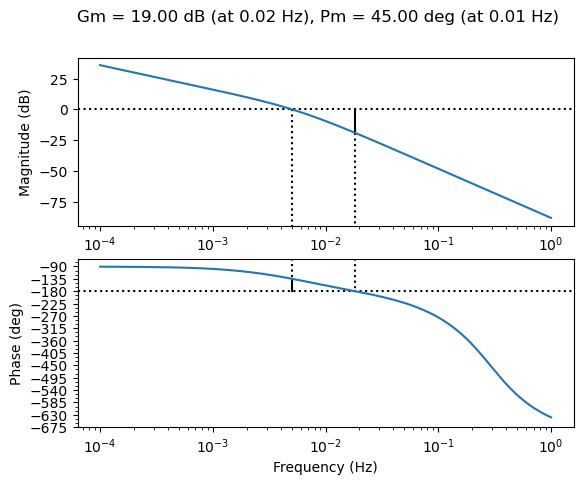

In [20]:
PIDSysPade=T*pade
mag, phase, omega= control.bode(PIDSysPade, plot=True, Hz=True, initial_phase=0, margins=True)

## Digital PID controller

### Recurrence equation  

> **Question:** - Discretize the PID controller in the form of a recurrence equation.


> **Exercice:** Define a PID function which returns    
> $o_k = o_{k-1} + K_i e_k T_s + K_p (e_k-e_{k-1}) +  \frac{K_d}{T_s}(e_k+ e_{k-2}-2e_{k-1})$  
> where $e_k$ is the error and $o_k$ the output of the controller. The `global` keyword defines variables which belongs to the global scope. 

In [21]:
T_s = 1
e_k_1 = 0 
e_k_2 = 0
o_k_1 = 0
K_p = Kp
K_i = Ki
K_d = Kd

def PID(order, measure):
    global o_k_1, e_k_1, e_k_2
    e_k = order - measure
    o_k=o_k_1 +  K_i*T_s*e_k + K_p*(e_k-e_k_1) + K_d/T_s*(e_k+ e_k_2-2*e_k_1)
    e_k_2 = e_k_1
    e_k_1 = e_k
    o_k_1 = max(0, min(100, o_k))
    return max(0, min(100, o_k))

### Real tests

The following cells can be used to test your controller. 
The first step is to check that your card is responding correctly.

In [23]:
%matplotlib inline
from tclab import TCLab
from tclab import clock # from tclab import clock

# Start TCLab
lab = TCLab()


TCLab version 1.0.0
Arduino Leonardo connected on port COM10 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.


In [24]:
tperiod = 20
tstep = 1

lab.Q1(100)

for t in clock(tperiod,tstep):
    print("Time %4.1f sec. : Temp = %.2f"%(t,lab.T1))
           
lab.Q1(0)

Time  0.0 sec. : Temp = 23.48
Time  1.0 sec. : Temp = 23.48
Time  2.0 sec. : Temp = 23.48
Time  3.0 sec. : Temp = 23.48
Time  4.0 sec. : Temp = 23.48
Time  5.0 sec. : Temp = 23.48
Time  6.0 sec. : Temp = 23.51
Time  7.0 sec. : Temp = 23.64
Time  8.0 sec. : Temp = 23.77
Time  9.0 sec. : Temp = 23.80
Time 10.0 sec. : Temp = 23.80
Time 11.0 sec. : Temp = 24.06
Time 12.0 sec. : Temp = 24.12
Time 13.0 sec. : Temp = 24.15
Time 14.0 sec. : Temp = 24.44
Time 15.0 sec. : Temp = 24.44
Time 16.0 sec. : Temp = 24.70
Time 17.0 sec. : Temp = 24.80
Time 18.0 sec. : Temp = 25.09
Time 19.0 sec. : Temp = 25.22
Time 20.0 sec. : Temp = 25.44


0.0

The following cell provides an initial implementation of PID control for heater T1.  

In [25]:
from tclab import clock
from tclab import TCLab

#from tclab import TCLab

#lab = TCLab()
#lab.LED(100)

# from tclab import TCLab

print("Temperature 1: %0.2f °C"%(lab.T1))
print("Temperature 2: %0.2f °C"%(lab.T2))

import matplotlib.pyplot as plt
import numpy as np

time = []
Q1 = []
Kperror = []
T1 = []

Torder =35

tfinal = 400
tstep = T_s

%matplotlib qt

# On active le mode interactif
plt.ion()   # ion => interactive on / ioff => interactive off
plt.figure()
plt.plot(time, T1,'b-', label='T1')
plt.plot(time, Q1,'r-', label='Q1')
plt.plot(time, np.ones(len(time))*Torder,'g-', label='Order')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C) - Puissance de chauffe /2 (%)')
plt.legend()
plt.show(block=False)

for t in clock(tfinal, tstep):
    Tmes=lab.T1
    Q = PID(Torder, Tmes)
    lab.Q1(Q)
    time = time + [t]
    T1 = T1 + [Tmes]
    Q1 = Q1 + [Q]

    Title='T1 = %.1f °C - Q1 = %.1f'%(Tmes,Q)
    plt.title(Title)
    plt.plot(time, T1,'b-')
    plt.plot(time, Q1,'y-')
    plt.plot(time, np.ones(len(time))*Torder,'g-')
    #plt.show(block=False)
    plt.pause(0.05)

   
plt.ioff()    
print("\nTurn Heater Q1 Off")
lab.Q1(0)
#lab.close()

Temperature 1: 25.41 °C
Temperature 2: 22.51 °C
9.268
100.48805444390554
8.945
97.2052610236876
8.623000000000001
94.40128691538334
8.43
92.91887726635755
8.300999999999998
92.09010672920628
7.978999999999999
89.24699112042718
7.721
87.04967416768214
7.591999999999999
86.17781151277208
7.334
83.95697319250567
7.0120000000000005
81.05508455428688
6.689
78.12322876885766
6.463999999999999
76.19058835781675
6.335000000000001
75.24232684250788
6.045000000000002
72.61240495870688
5.722999999999999
69.63217254081093
5.399999999999999
66.6219729757046
5.109999999999999
63.93522298174214
5.077999999999999
63.91311757585237
4.756
60.87411212851677
4.434000000000001
57.81553593094375
4.111000000000001
54.72699258616031
3.7890000000000015
51.62921410938501
3.596
49.8530000918882
3.4669999999999987
48.73042518626589
3.1449999999999996
45.59350520901576
2.8220000000000027
42.42661808455524
2.5319999999999965
39.58318053123848
2.371000000000002
38.06325235647862
2.146000000000001
35.868169400328505


-0.3999999999999986
14.83577894424657
-0.3999999999999986
14.811467453268413
-0.3999999999999986
14.787155962290257
-0.3999999999999986
14.7628444713121
-0.4650000000000034
14.062767177089432
-0.3999999999999986
14.710270872071833
-0.3999999999999986
14.685959381093674
-0.3999999999999986
14.661647890115518
-0.43299999999999983
14.294255299028622
-0.3999999999999986
14.611019210153504
-0.43299999999999983
14.243626619066609
-0.3999999999999986
14.56039053019149
-0.43299999999999983
14.192997939104595
-0.43299999999999983
14.16668075012074
-0.3999999999999986
14.483444661245624
-0.43299999999999983
14.116052070158728
-0.3999999999999986
14.43281598128361
-0.4650000000000034
13.732738687060943
-0.4650000000000034
13.704476578798834
-0.43299999999999983
14.008899173672498
-0.43299999999999983
13.982581984688643
-0.4650000000000034
13.623580092569016
-0.43299999999999983
13.92800268744268
-0.4969999999999999
13.236316092187355
-0.4650000000000034
13.538793767782693
-0.43299999999999983
13.

0.0

In [ ]:
print("\nTurn Heater Q1 Off")
lab.Q1(0)

Finally, you can display the temperature and power curves:

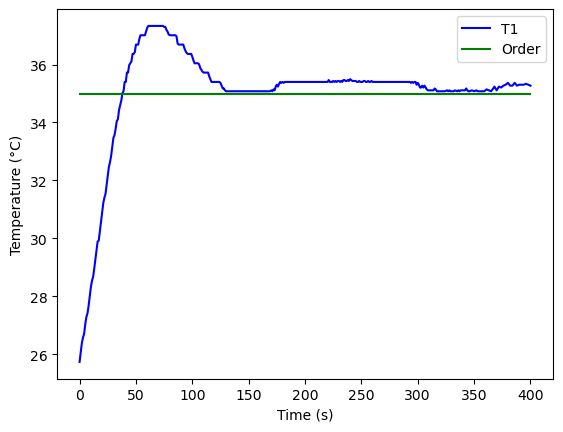

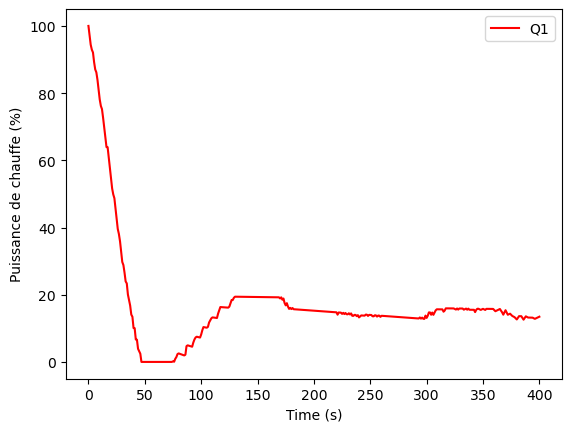

In [26]:
%matplotlib inline

plt.ioff()  
plt.plot(time, T1,'b-', label='T1')
plt.plot(time, np.ones(len(time))*Torder,'g-', label='Order')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

plt.plot(time, Q1,'r-', label='Q1')
plt.xlabel('Time (s)')
plt.ylabel('Puissance de chauffe (%)')
plt.legend()
plt.show()